In [24]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report



In [47]:
main_dir = "/media/ist/Drive2/MANSOOR/Neuroimaging-Project/Breast_Cancer_Classification_Project"
weights_dir = "Model_Weights"
model_filenames = {"ResNet18": "ResNet18_best_model_epoch_19.pth", 
                   "ResNet50": "ResNet50_best_model_epoch_14.pth", 
                   "DenseNet" : "DenseNet_best_model_ben_vs_mal.pth"}
pos_neg_dir = f"{main_dir}/Tiles_Data"
ben_mal_dir = f"{main_dir}/Tiles_Data_Cat_Classification"
batch_size = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Breast cancer positive/negative classification results

In [14]:
data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

In [15]:
def load_data(img_files_dir):
    image_datasets = {x: datasets.ImageFolder(os.path.join(img_files_dir, x), data_transforms[x])
                        for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
                    for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names

In [48]:
def load_and_evaluate_model(model_path, img_files_dir, phase='val'):
    """Load the saved model and evaluate it on the test set."""
    model = models.resnet50(pretrained=False) 
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) 
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    dataloaders, dataset_sizes, _ = load_data(img_files_dir)

    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())

    return true_labels, predictions

def plot_confusion_matrix(conf_matrix, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_classification_report(true_labels, predictions, target_classes):
    report = classification_report(true_labels, predictions, target_names=target_classes, zero_division=0)
    print("Classification Report:\n", report)

def show_classification_results(true_labels, predictions, target_classes):
    # Calculate metrics
    conf_matrix = confusion_matrix(true_labels, predictions)

    plot_confusion_matrix(conf_matrix, classes=target_classes)
    print_classification_report(true_labels, predictions, target_classes)


/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


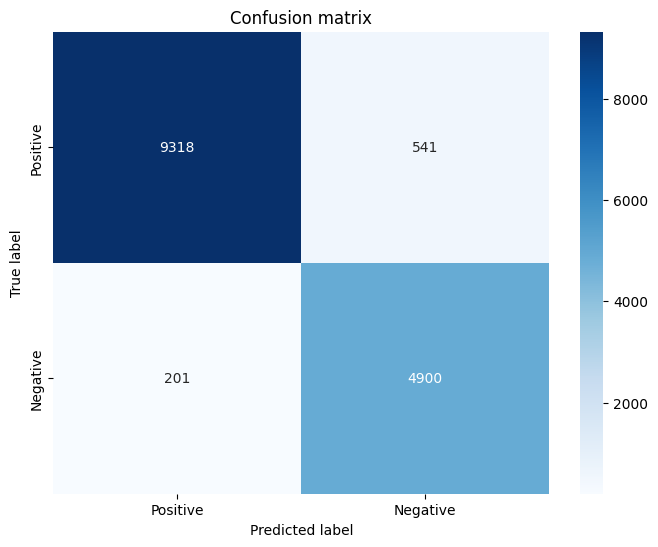

Classification Report:
               precision    recall  f1-score   support

    Positive       0.98      0.95      0.96      9859
    Negative       0.90      0.96      0.93      5101

    accuracy                           0.95     14960
   macro avg       0.94      0.95      0.95     14960
weighted avg       0.95      0.95      0.95     14960



In [45]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["ResNet18"]}", pos_neg_dir)
target_classes = ['Positive', 'Negative']
show_classification_results(true_labels, predictions, target_classes)

/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/ist/Drive2/DL-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


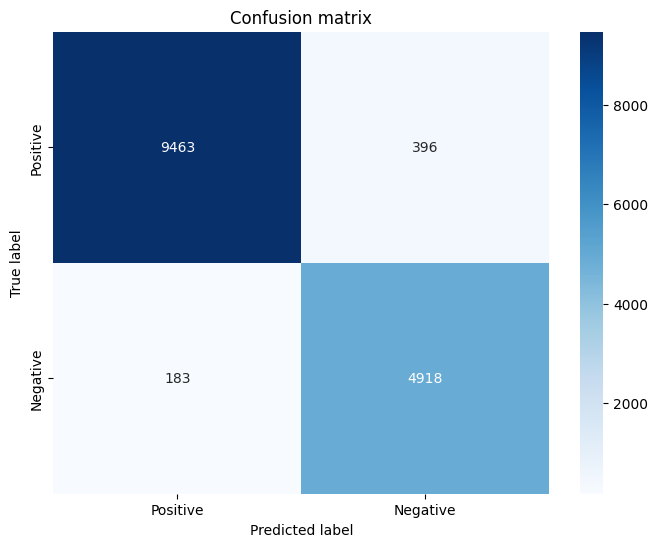

Classification Report:
               precision    recall  f1-score   support

    Positive       0.98      0.96      0.97      9859
    Negative       0.93      0.96      0.94      5101

    accuracy                           0.96     14960
   macro avg       0.95      0.96      0.96     14960
weighted avg       0.96      0.96      0.96     14960



In [49]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["ResNet50"]}", pos_neg_dir)
target_classes = ['Positive', 'Negative']
show_classification_results(true_labels, predictions, target_classes)

In [ ]:
true_labels, predictions = load_and_evaluate_model(f"{weights_dir}/{model_filenames["DenseNet"]}", ben_mal_dir)
target_classes = ['Benign', 'Malignant']
show_classification_results(true_labels, predictions, target_classes)